In [42]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET

# Define the paths to your image and annotation folders
path_image = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/image"
path_annotations = "/Users/sumaiyauddin/Documents/Semester03/CCNY-DSE-Capstone-Project-Segmenting-Coral-Branch-tips/data/external/Coral_images/annotation"

# Initialize lists to store images, labels, and masks
images = []
labels = []
masks = []

# Initialize counters for the classes
apal_count = 0
pseudodiploria_count = 0

# Set the desired balance ratio
desired_balance_ratio = 0.5  # 50% APAL, 50% Pseudodiploria

# Initialize counters for oversampling APAL and undersampling Pseudodiploria
oversample_apal = True
undersample_pseudodiploria = False

# Iterate through each image file in the image folder
for image_filename in os.listdir(path_image):
    if image_filename.lower().endswith(".jpg"):  # Check for image files
        image_path = os.path.join(path_image, image_filename)

        # Load the image using OpenCV
        image = cv2.imread(image_path)

        # Check if the image was loaded successfully
        if image is not None:
            # Resize the image to 224x224 if needed
            if image.shape[0] >= 224 and image.shape[1] >= 224:
                image = cv2.resize(image, (224, 224))
            else:
                print(f"Image dimensions are too small for resizing: {image_path}")

            # Load the corresponding label (XML file)
            xml_filename = os.path.splitext(image_filename)[0] + ".xml"
            xml_path = os.path.join(path_annotations, xml_filename)

            # Check if the XML file exists
            if os.path.exists(xml_path):
                # Parse the XML file to extract the label (you may need to adjust this based on your XML structure)
                tree = ET.parse(xml_path)
                root = tree.getroot()

                # Initialize a binary mask for this image
                mask = np.zeros(image.shape[:2], dtype=np.uint8)

                # Find the "name" element and check if it exists
                name_element = root.find("object/name")
                if name_element is not None:
                    label = name_element.text  # Use .text to get the text content of the element

                    # Check the class label and balance the dataset
                    if label == "APAL":
                        apal_count += 1
                    elif label == "Pseudodiploria":
                        pseudodiploria_count += 1

                    # Find the polygon points and draw the mask
                    polygon = root.find("object/polygon")
                    if polygon is not None:
                        points = []
                        for pt in polygon.findall("pt"):
                            x = int(pt.find("x").text)
                            y = int(pt.find("y").text)
                            points.append((x, y))
                        points = np.array(points, dtype=np.int32)
                        cv2.fillPoly(mask, [points], 1)

                    # Append the image, label, and mask to the lists
                    images.append(image)
                    labels.append(label)
                    masks.append(mask)

                else:
                    # Handle the case where the "name" element is missing
                    print(f"'name' element not found in XML file: {xml_path}")
            else:
                # Handle the case where the XML label file is missing
                print(f"XML label file not found for image: {image_path}")

# Calculate the oversampling and undersampling factors
if apal_count < pseudodiploria_count:
    oversample_factor = pseudodiploria_count / apal_count
    undersample_factor = 1.0
else:
    oversample_factor = 1.0
    undersample_factor = apal_count / pseudodiploria_count

# Apply oversampling and undersampling
oversample_apal = oversample_apal and apal_count < pseudodiploria_count
undersample_pseudodiploria = undersample_pseudodiploria and apal_count > pseudodiploria_count

# Initialize lists to store oversampled data
oversampled_images = []
oversampled_labels = []
oversampled_masks = []

for i in range(len(images)):
    if labels[i] == "APAL" and oversample_apal:
        for _ in range(int(oversample_factor)):
            oversampled_images.append(images[i])
            oversampled_labels.append(labels[i])
            oversampled_masks.append(masks[i])
    elif labels[i] == "Pseudodiploria" and undersample_pseudodiploria:
        if np.random.rand() < 1 / undersample_factor:
            continue

    oversampled_images.append(images[i])
    oversampled_labels.append(labels[i])
    oversampled_masks.append(masks[i])

# Convert the lists to NumPy arrays
images = np.array(oversampled_images)
masks = np.array(oversampled_masks)
labels = np.array(oversampled_labels)

# Now, you have NumPy arrays for images, masks, and labels
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Labels shape: {labels.shape}")

# Check class distribution
unique_labels, class_counts = np.unique(labels, return_counts=True)
for label, count in zip(unique_labels, class_counts):
    print(f"Class: {label}, Count: {count}")


Images shape: (1595, 224, 224, 3)
Masks shape: (1595, 224, 224)
Labels shape: (1595,)
Class: APAL, Count: 812
Class: Pseudodiploria, Count: 783


In [43]:
from sklearn.model_selection import train_test_split
import pickle

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Save your data to a pickle file
with open('../data/external/data_RCNN.pkl', 'wb') as f:
    pickle.dump((X_train, y_train, X_test, y_test), f)

# Check the shapes
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')


X_train shape: (1276, 224, 224, 3)
y_train shape: (1276, 224, 224)
X_test shape: (319, 224, 224, 3)
y_test shape: (319, 224, 224)


## Without oversampling

In [54]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET

# Define the paths to your image and annotation folders
path_image = "/Users/sumaiyauddin/Documents/Semester03/Coral_images/APAL"
path_annotations = "/Users/sumaiyauddin/Documents/Semester03/Coral_images/APAL"

# Initialize lists to store images, labels, and masks
images = []
labels = []
masks = []

# Common image size (e.g., 224x224)
common_image_size = (224, 224)

# Iterate through each XML file in the annotation folder
for xml_filename in os.listdir(path_annotations):
    if xml_filename.lower().endswith(".xml"):
        xml_path = os.path.join(path_annotations, xml_filename)

        # Extract the corresponding image filename
        image_filename = xml_filename.replace(".xml", ".jpg")
        image_path = os.path.join(path_image, image_filename)

        # Check if the image file exists
        if not os.path.exists(image_path):
            print(f"Image not found for XML: {xml_filename}")
            continue

        # Parse the XML file to extract the label and bounding box coordinates
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Initialize a mask for the original-sized image
        original_image = cv2.imread(image_path)
        original_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)

        for object_elem in root.findall("object"):
            name_elem = object_elem.find("name")
            bndbox_elem = object_elem.find("bndbox")

            if name_elem is not None and bndbox_elem is not None:
                label = name_elem.text
                xmin = int(bndbox_elem.find("xmin").text)
                ymin = int(bndbox_elem.find("ymin").text)
                xmax = int(bndbox_elem.find("xmax").text)
                ymax = int(bndbox_elem.find("ymax").text)

                # Create a binary mask using the bounding box coordinates
                object_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
                object_mask[ymin:ymax, xmin:xmax] = 1

                # Add the object mask to the composite mask
                original_mask = np.maximum(original_mask, object_mask)

        # Resize the original-sized image and mask to the common size
        image = cv2.resize(original_image, common_image_size)
        mask = cv2.resize(original_mask, common_image_size)

        # Append the resized image and label to the lists
        images.append(image)
        labels.append(label)

        # Append the resized mask to the masks list
        masks.append(mask)

# Convert the lists to NumPy arrays
images = np.array(images)
masks = np.array(masks)
labels = np.array(labels)

# Now, you have NumPy arrays for the resized images, masks, and labels
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Labels shape: {labels.shape}")


Images shape: (117, 224, 224, 3)
Masks shape: (117, 224, 224)
Labels shape: (117,)


In [56]:
import pickle

# Save the augmented images to a pickle file
with open('images_rcnn.pkl', 'wb') as file:
    pickle.dump(images, file)

# Save the augmented labels (masks) to a pickle file
with open('masks_rcnn.pkl', 'wb') as file:
    pickle.dump(masks, file)


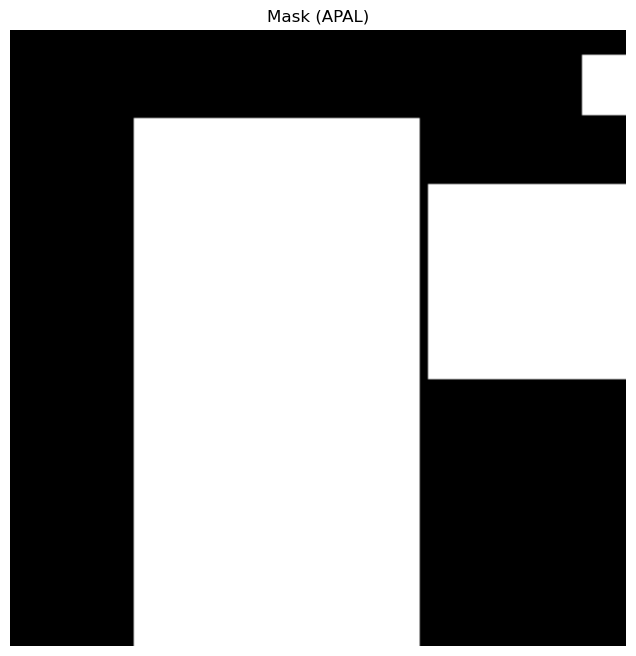

In [32]:
import matplotlib.pyplot as plt
import random

# Choose the number of masks you want to display
num_masks_to_display = 1

# Generate random indices for selecting masks
random_indices = random.sample(range(len(masks)), num_masks_to_display)

# Display the selected masks
for i, idx in enumerate(random_indices):
    mask = masks[idx]
    label = labels[idx]

    # Create a subplot for each mask
    plt.figure(figsize=(8, 8))
    
    plt.subplot(1, num_masks_to_display, i + 1)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask ({label})")
    plt.axis('off')

plt.show()


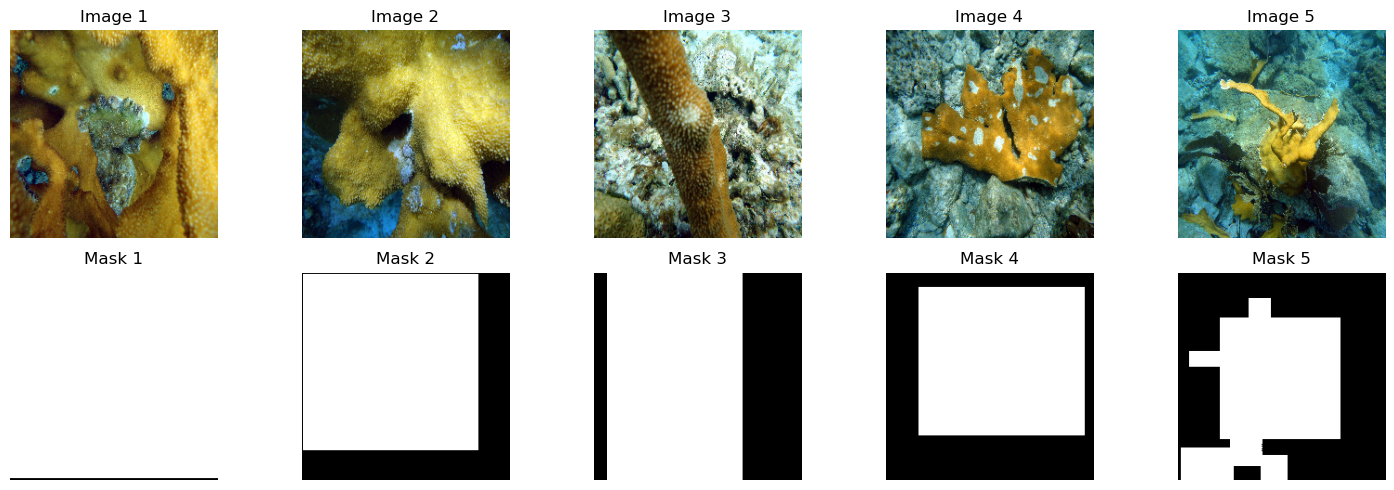

In [34]:
# Number of image-mask pairs to display
num_pairs_to_display = 5

# Create a figure with subplots
fig, axes = plt.subplots(2, num_pairs_to_display, figsize=(15, 5))

# Display the first 5 image-mask pairs
for i in range(num_pairs_to_display):
    axes[0, i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axes[0, i].set_title(f"Image {i + 1}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(masks[i], cmap='gray')
    axes[1, i].set_title(f"Mask {i + 1}")
    axes[1, i].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [35]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET

# Define the paths to your image and annotation folders
path_image = "/Users/sumaiyauddin/Documents/Semester03/Coral_images/Pseudodiploria"
path_annotations = "/Users/sumaiyauddin/Documents/Semester03/Coral_images/Pseudodiploria"

# Initialize lists to store images, labels, and masks
images = []
labels = []
masks = []

# Common image size (e.g., 224x224)
common_image_size = (224, 224)

# Iterate through each XML file in the annotation folder
for xml_filename in os.listdir(path_annotations):
    if xml_filename.lower().endswith(".xml"):
        xml_path = os.path.join(path_annotations, xml_filename)

        # Extract the corresponding image filename
        image_filename = xml_filename.replace(".xml", ".jpg")
        image_path = os.path.join(path_image, image_filename)

        # Check if the image file exists
        if not os.path.exists(image_path):
            print(f"Image not found for XML: {xml_filename}")
            continue

        # Parse the XML file to extract the label and bounding box coordinates
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Initialize a mask for the original-sized image
        original_image = cv2.imread(image_path)
        original_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)

        for object_elem in root.findall("object"):
            name_elem = object_elem.find("name")
            bndbox_elem = object_elem.find("bndbox")

            if name_elem is not None and bndbox_elem is not None:
                label = name_elem.text
                xmin = int(bndbox_elem.find("xmin").text)
                ymin = int(bndbox_elem.find("ymin").text)
                xmax = int(bndbox_elem.find("xmax").text)
                ymax = int(bndbox_elem.find("ymax").text)

                # Create a binary mask using the bounding box coordinates
                object_mask = np.zeros(original_image.shape[:2], dtype=np.uint8)
                object_mask[ymin:ymax, xmin:xmax] = 1

                # Add the object mask to the composite mask
                original_mask = np.maximum(original_mask, object_mask)

        # Resize the original-sized image and mask to the common size
        image = cv2.resize(original_image, common_image_size)
        mask = cv2.resize(original_mask, common_image_size)

        # Append the resized image and label to the lists
        images.append(image)
        labels.append(label)

        # Append the resized mask to the masks list
        masks.append(mask)

# Convert the lists to NumPy arrays
images = np.array(images)
masks = np.array(masks)
labels = np.array(labels)

# Now, you have NumPy arrays for the resized images, masks, and labels
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Labels shape: {labels.shape}")


Images shape: (782, 224, 224, 3)
Masks shape: (782, 224, 224)
Labels shape: (782,)


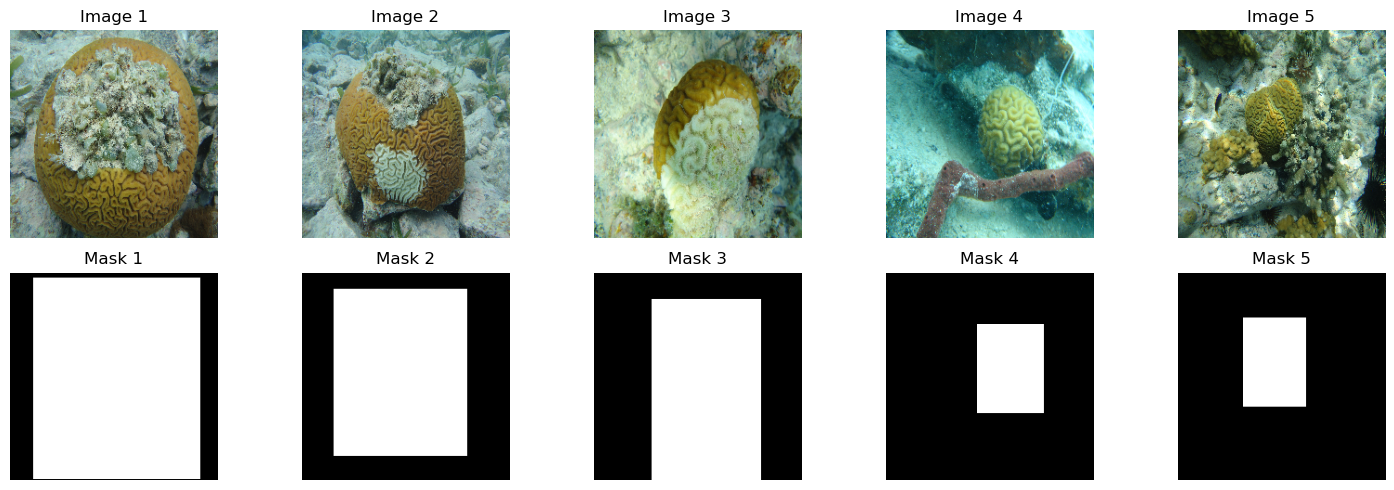

In [36]:
# Number of image-mask pairs to display
num_pairs_to_display = 5

# Create a figure with subplots
fig, axes = plt.subplots(2, num_pairs_to_display, figsize=(15, 5))

# Display the first 5 image-mask pairs
for i in range(num_pairs_to_display):
    axes[0, i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    axes[0, i].set_title(f"Image {i + 1}")
    axes[0, i].axis('off')
    
    axes[1, i].imshow(masks[i], cmap='gray')
    axes[1, i].set_title(f"Mask {i + 1}")
    axes[1, i].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

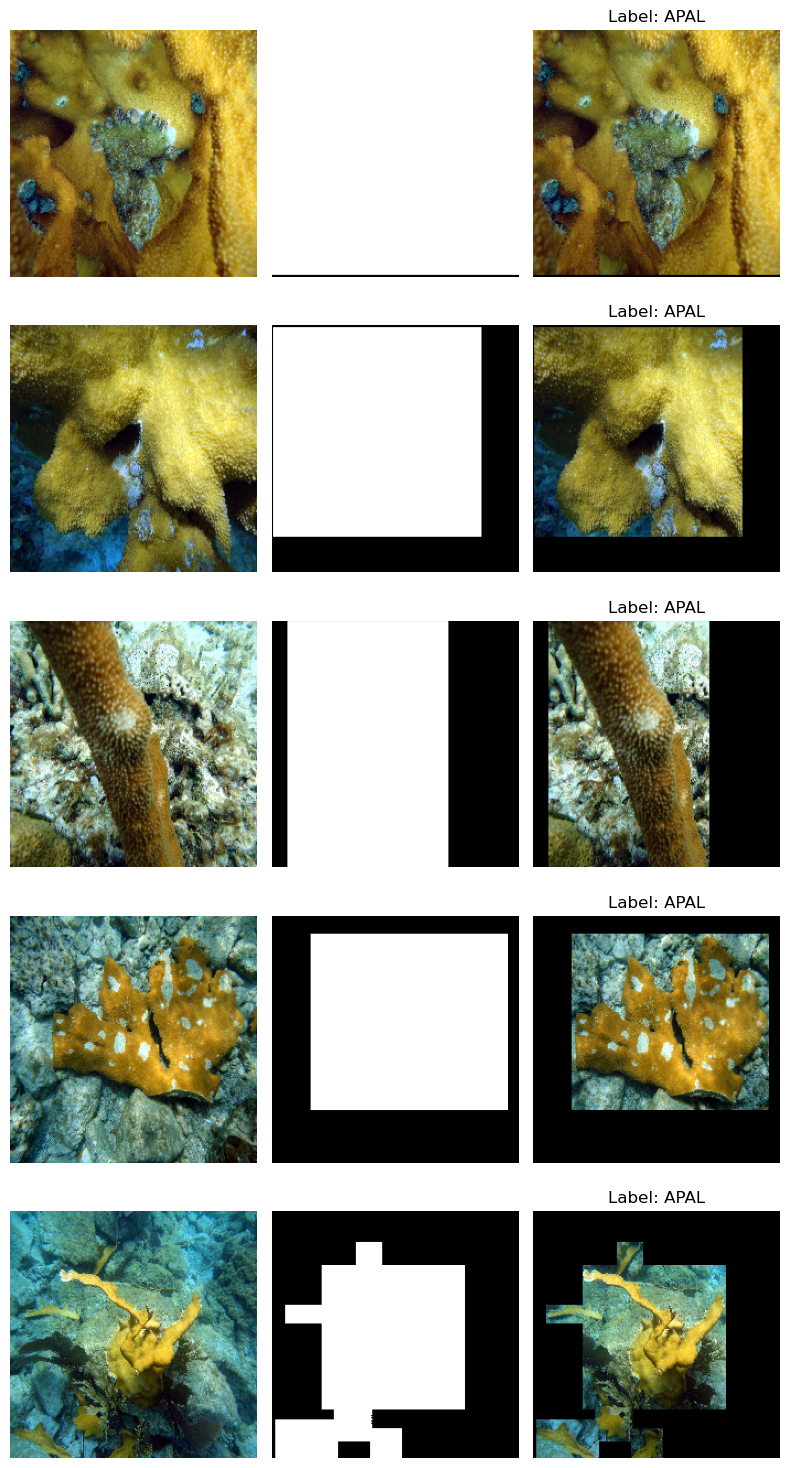

In [57]:
import matplotlib.pyplot as plt
import cv2

# Number of image-mask pairs to display
num_pairs_to_display = 5

# Create a figure with subplots
fig, axes = plt.subplots(num_pairs_to_display, 3, figsize=(8, 15))

# Display the first 5 image-mask pairs
for i in range(num_pairs_to_display):
    image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    mask = masks[i]
    label = labels[i]

    # Create a new image with only the masked region
    masked_region = cv2.bitwise_and(image, image, mask=mask)

    # Plot the original image
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')

    # Plot the mask
    axes[i, 1].imshow(mask, cmap='gray')
    axes[i, 1].axis('off')

    # Plot the masked region
    axes[i, 2].imshow(masked_region)
    axes[i, 2].set_title(f"Label: {label}")
    axes[i, 2].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()
